In [1]:
import numpy as np
import pandas as pd

In [2]:
cc_df= pd.read_csv('creditcard.csv')

In [3]:
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
cc_df.shape

(284807, 31)

The determination of whether this transaction is determined to be legitimate or fraudulent is encoded in the 'Class' field:

In [5]:
cc_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
type(cc_df['Class'].value_counts())

pandas.core.series.Series

In [2]:
import sys

In [3]:
sys.path.append('deep_tabular_augmentation')
sys.path.append('ml_prepare')

In [4]:
import mlprepare as mlp
import deep_tabular_augmentation as dta

In [5]:
wine_df = pd.read_csv('wine.csv')

In [6]:
wine_df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [7]:
wine_df.shape

(178, 14)

In [8]:
wine_df = wine_df.fillna(-99)

In [11]:
wine_df.columns

Index(['Wine', 'Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols',
       'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue',
       'OD', 'Proline'],
      dtype='object')

In [18]:
wine_df['Wine'].value_counts()

2    71
1    59
3    48
Name: Wine, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = mlp.split_df(wine_df, dep_var='Wine', test_size=0.3, split_mode='random')

In [10]:
from sklearn.preprocessing import StandardScaler
from functools import partial

In [11]:
x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

In [12]:
datasets = dta.create_datasets(X_train.values, y_train.values, X_test.values, y_test.values)

In [13]:
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

In [14]:
import torch
from torch import nn
from torch import optim

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
D_in = X_train.values.shape[1]

model = dta.Autoencoder(nn.Sequential(*dta.get_lin_layers(D_in, [50, 12, 12])),
                     nn.Sequential(*dta.get_lin_layers_rev(D_in, [50, 12, 12])),
                     latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [17]:
learn = dta.Learner(model, opt, loss_func, data, 'Wine', 1, list(wine_df.columns))

In [18]:
run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

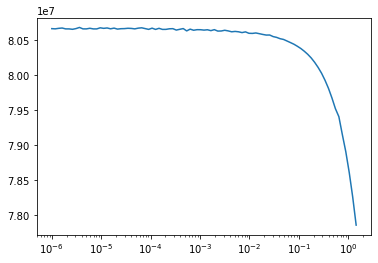

In [19]:
run.recorder.plot(skip_last=5)

In [20]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.05), dta.sched_cos(0.05, 0.01)])

In [21]:
cbfs = [partial(dta.LossTracker, show_every=200), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(nn.Sequential(*dta.get_lin_layers(D_in, [50, 12, 12])),
                     nn.Sequential(*dta.get_lin_layers_rev(D_in, [50, 12, 12])),
                     latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, 'Wine', 1, list(wine_df.columns))
run = dta.Runner(cb_funcs=cbfs)
run.fit(1000, learn)

epoch: 200
train loss is: 80648104.0
validation loss is: 38110304.0
epoch: 400
train loss is: 80102912.0
validation loss is: 37747640.0
epoch: 600
train loss is: 79039472.0
validation loss is: 37205028.0
epoch: 800
train loss is: 77840144.0
validation loss is: 36650500.0
epoch: 1000
train loss is: 76793312.0
validation loss is: 36163336.0


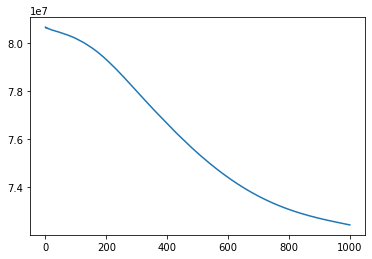

In [22]:
run.recorder.plot_loss()

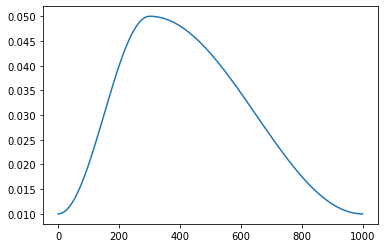

In [23]:
run.recorder.plot_lr()

In [24]:
df_fake = run.predict_df(learn, no_samples=10000, scaler=x_scaler)

In [25]:
df_fake.head()

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline,Wine
0,23.116503,6.492592,2.962373,81.253204,637.731384,3.243215,2.592419,0.410407,2.176052,20.690186,1.128694,3.617118,7113.085449,1
1,23.468784,6.558426,2.983496,84.087585,640.520874,3.202832,2.427513,0.415410,2.198167,25.448952,1.110760,3.399372,7390.093262,1
2,23.227234,6.437524,2.960296,80.410576,633.770142,3.276946,2.655821,0.410816,2.222498,22.118162,1.127313,3.599967,7337.514160,1
3,23.341997,6.585497,2.977226,83.464050,641.218872,3.194858,2.443899,0.414000,2.174459,23.718330,1.116208,3.452576,7257.360352,1
4,23.175762,6.405844,2.958805,80.288246,632.997131,3.272480,2.657567,0.410733,2.205462,21.298512,1.129772,3.623363,7266.006348,1


In [26]:
torch.save(model.to('cpu').state_dict(), 'model.pth')

In [27]:
state_dict = torch.load('model.pth')

In [29]:
mu,logvar = run._get_embeddings()

In [30]:
sigma = torch.exp(logvar / 2)

In [31]:
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))

In [32]:
z = q.rsample(sample_shape=torch.Size([200]))

In [33]:
with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

In [34]:
pred.shape

(200, 13)

In [35]:
dup_model = dta.Autoencoder(nn.Sequential(*dta.get_lin_layers(D_in, [50, 12, 12])),
                     nn.Sequential(*dta.get_lin_layers_rev(D_in, [50, 12, 12])),
                     latent_dim=5).to(device)

In [36]:
state_from_file = torch.load('model.pth')

In [37]:
dup_model.load_state_dict(state_from_file)

<All keys matched successfully>

In [38]:
with torch.no_grad():
    pred2 = dup_model.decode(z).cpu().numpy()

In [39]:
pred2.shape

(200, 13)